# Keras on the datamillcloud/pydl_env:latest notebook

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8258016637342860359
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6170077273488214182
physical_device_desc: "device: XLA_CPU device"
]


Using TensorFlow backend.


x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


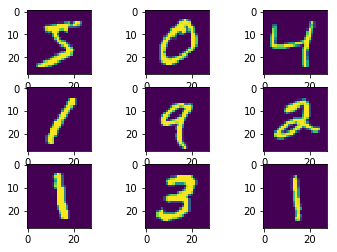

In [2]:
%matplotlib inline

import keras
#from keras.datasets import cifar10
from keras.datasets import mnist

from matplotlib import pyplot
from matplotlib.pyplot import imshow
import numpy as np

# https://keras.io/datasets/#mnist-database-of-handwritten-digits
# load mnist in a grayscale format bunch of images
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    imshow(x_train[i])
    imgplot = pyplot.imshow(x_train[i])

(60000, 28, 28)
(60000,)
First image is a 5


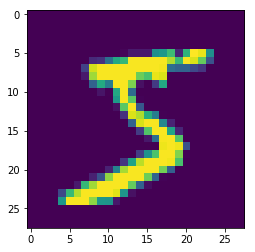

In [3]:
print(x_train.shape)
print(y_train.shape)

# since we deal with square images
image_size = x_train.shape[1]

# inspect the format of x and y
print("First image is a", y_train[0])
pyplot.imshow(x_train[0])

In [4]:
initial_seed = 1234
np.random.seed(initial_seed)

In [5]:
print(np.amax(x_train))
# normalize the pixel values to have everything between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

255


In [6]:
# https://github.com/keras-team/keras/blob/master/examples/mnist_denoising_autoencoder.py
# https://blog.keras.io/building-autoencoders-in-keras.html
# x_train_ = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train_ = np.reshape(x_train, (len(x_train), image_size, image_size, 1))
print("Reshaped train from", x_train.shape, "to", x_train_.shape)

#x_test_ = np.reshape(x_test, [-1, image_size, image_size, 1])
x_test_ = np.reshape(x_test, (len(x_test), image_size, image_size, 1))
print("Reshaped test from", x_test.shape, "to", x_test_.shape)

Reshaped train from (60000, 28, 28) to (60000, 28, 28, 1)
Reshaped test from (10000, 28, 28) to (10000, 28, 28, 1)


In [7]:
# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5,
                         scale=0.5,
                         size=x_train_.shape)
print("x_train noise.shape", noise.shape)
x_train_noisy = x_train_ + noise
noise = np.random.normal(loc=0.5,
                         scale=0.5,
                         size=x_test_.shape)
x_test_noisy = x_test_ + noise
print("x_test noise.shape", noise.shape)

# make sure the data are in the [0,1] range by clipping lower and higher ones
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

x_train noise.shape (60000, 28, 28, 1)
x_test noise.shape (10000, 28, 28, 1)


Let's see how noisy became the first training entry after adding the noise:

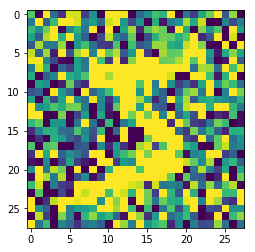

In [8]:
pyplot.imshow(
    np.reshape(x_train_noisy[0], (1, image_size, image_size))[0]
)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD, rmsprop
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D

model = Sequential()
model.add(Conv2D(16, (3, 3), 
                 input_shape=x_train_.shape[1:], # (28, 28)
                 activation='relu',
                 padding='same'))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding="same"))

# ** encoded representation **
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
          
model.compile(optimizer='adadelta', loss='binary_crossentropy')

In [16]:
model.fit(x_train_noisy, 
          x_train_,
          epochs=1, # am lazy to wait, and this is just a demo!
          batch_size=128,
          shuffle=True,
          validation_data=(x_test_noisy, x_test_))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 193s 3ms/step - loss: 0.1861 - val_loss: 0.1791


Sorry, I am lazy to wait for 50 epochs, so I just killed it, feel free to continue it further:

In [17]:
# example prediction on the corrupted test images
decoded = model.predict(
    # only predict the first element as example
    np.reshape(x_test_noisy[0], (1, image_size, image_size, 1))
)

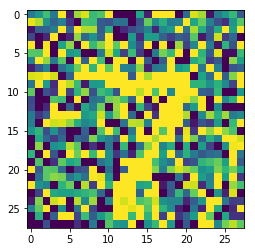

In [18]:
pyplot.imshow(
    np.reshape(x_test_noisy[0], (1, image_size, image_size))[0]
)

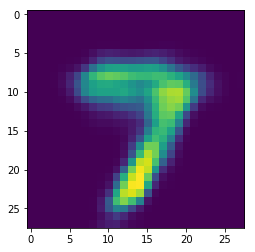

In [19]:
pyplot.imshow(
    np.reshape(decoded, (1, image_size, image_size))[0]
)